In [1]:
import pandas as pd
import numpy as np

import sys, os, h5py
sys.path.append(os.path.abspath('../../GCN/'))
import gcnIO

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
F = np.load('../../data/pancancer/multiomics_features_raw_fpkm.npy')
with h5py.File('../../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels.h5', 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None
    if 'feature_names' in f:
        feature_names = f['feature_names'][:]
    else:
        feature_names = None

print (feature_names.shape, features.shape, node_names.shape, F.shape)
#idx = np.array([i for i in range(F.shape[1]) if i < 23 or i > 34])
F_df = pd.DataFrame(F, index=node_names[:, 1], columns=feature_names)
F.shape, F_df.shape
#F_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)

(35,) (12129, 35) (12129, 2) (12129, 35)


((12129, 35), (12129, 35))

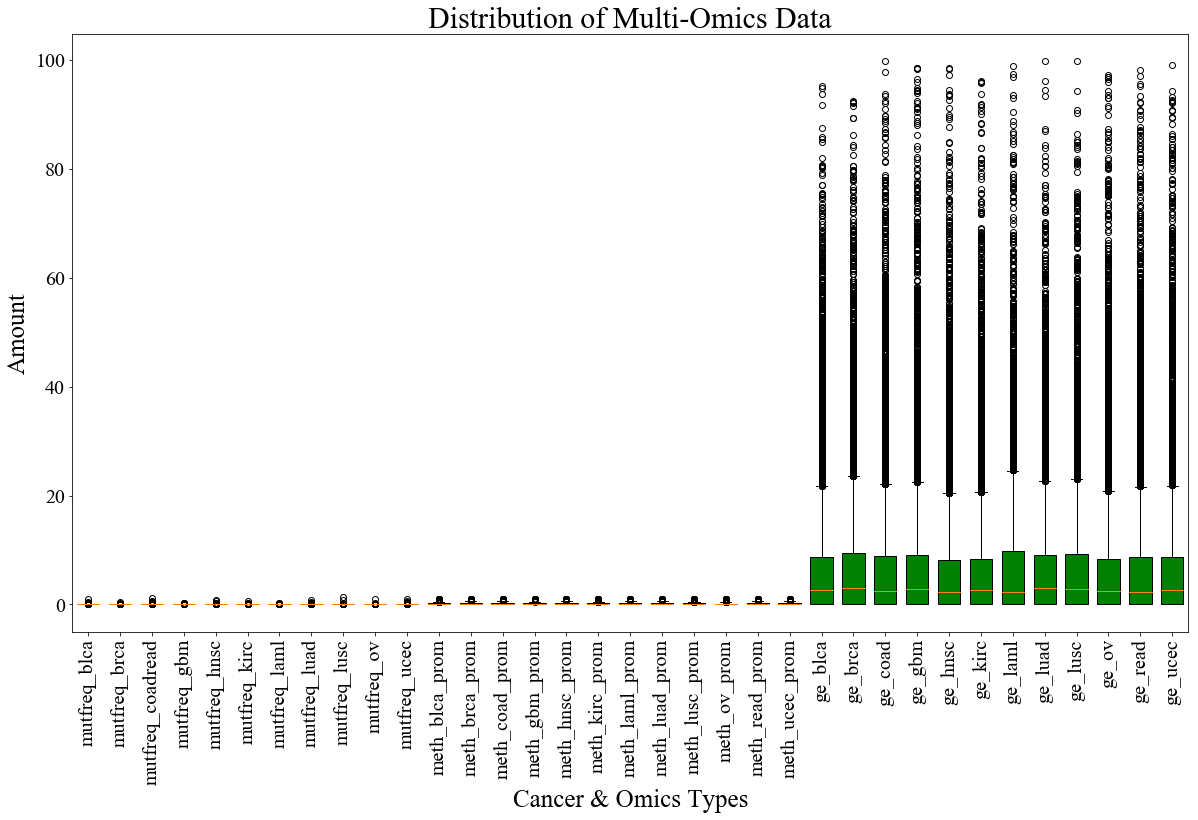

In [7]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# plot
x = plt.boxplot(F_df.values, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, features.shape[1]+1), feature_names, rotation='vertical', fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*11 + ['blue']*12 + ['green']*12
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 1.5])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.title('Distribution of Multi-Omics Data', fontsize=30)
fig.savefig('multiomics_distro_minmax_nogenebodymeth.svg')

In [8]:
F_df_nomutfreq = F_df.iloc[:, 11:]
F_valid = F_df[(F_df_nomutfreq == 0).sum(axis=1) < 3]
F_df.shape, F_valid.shape

((12129, 35), (8974, 35))

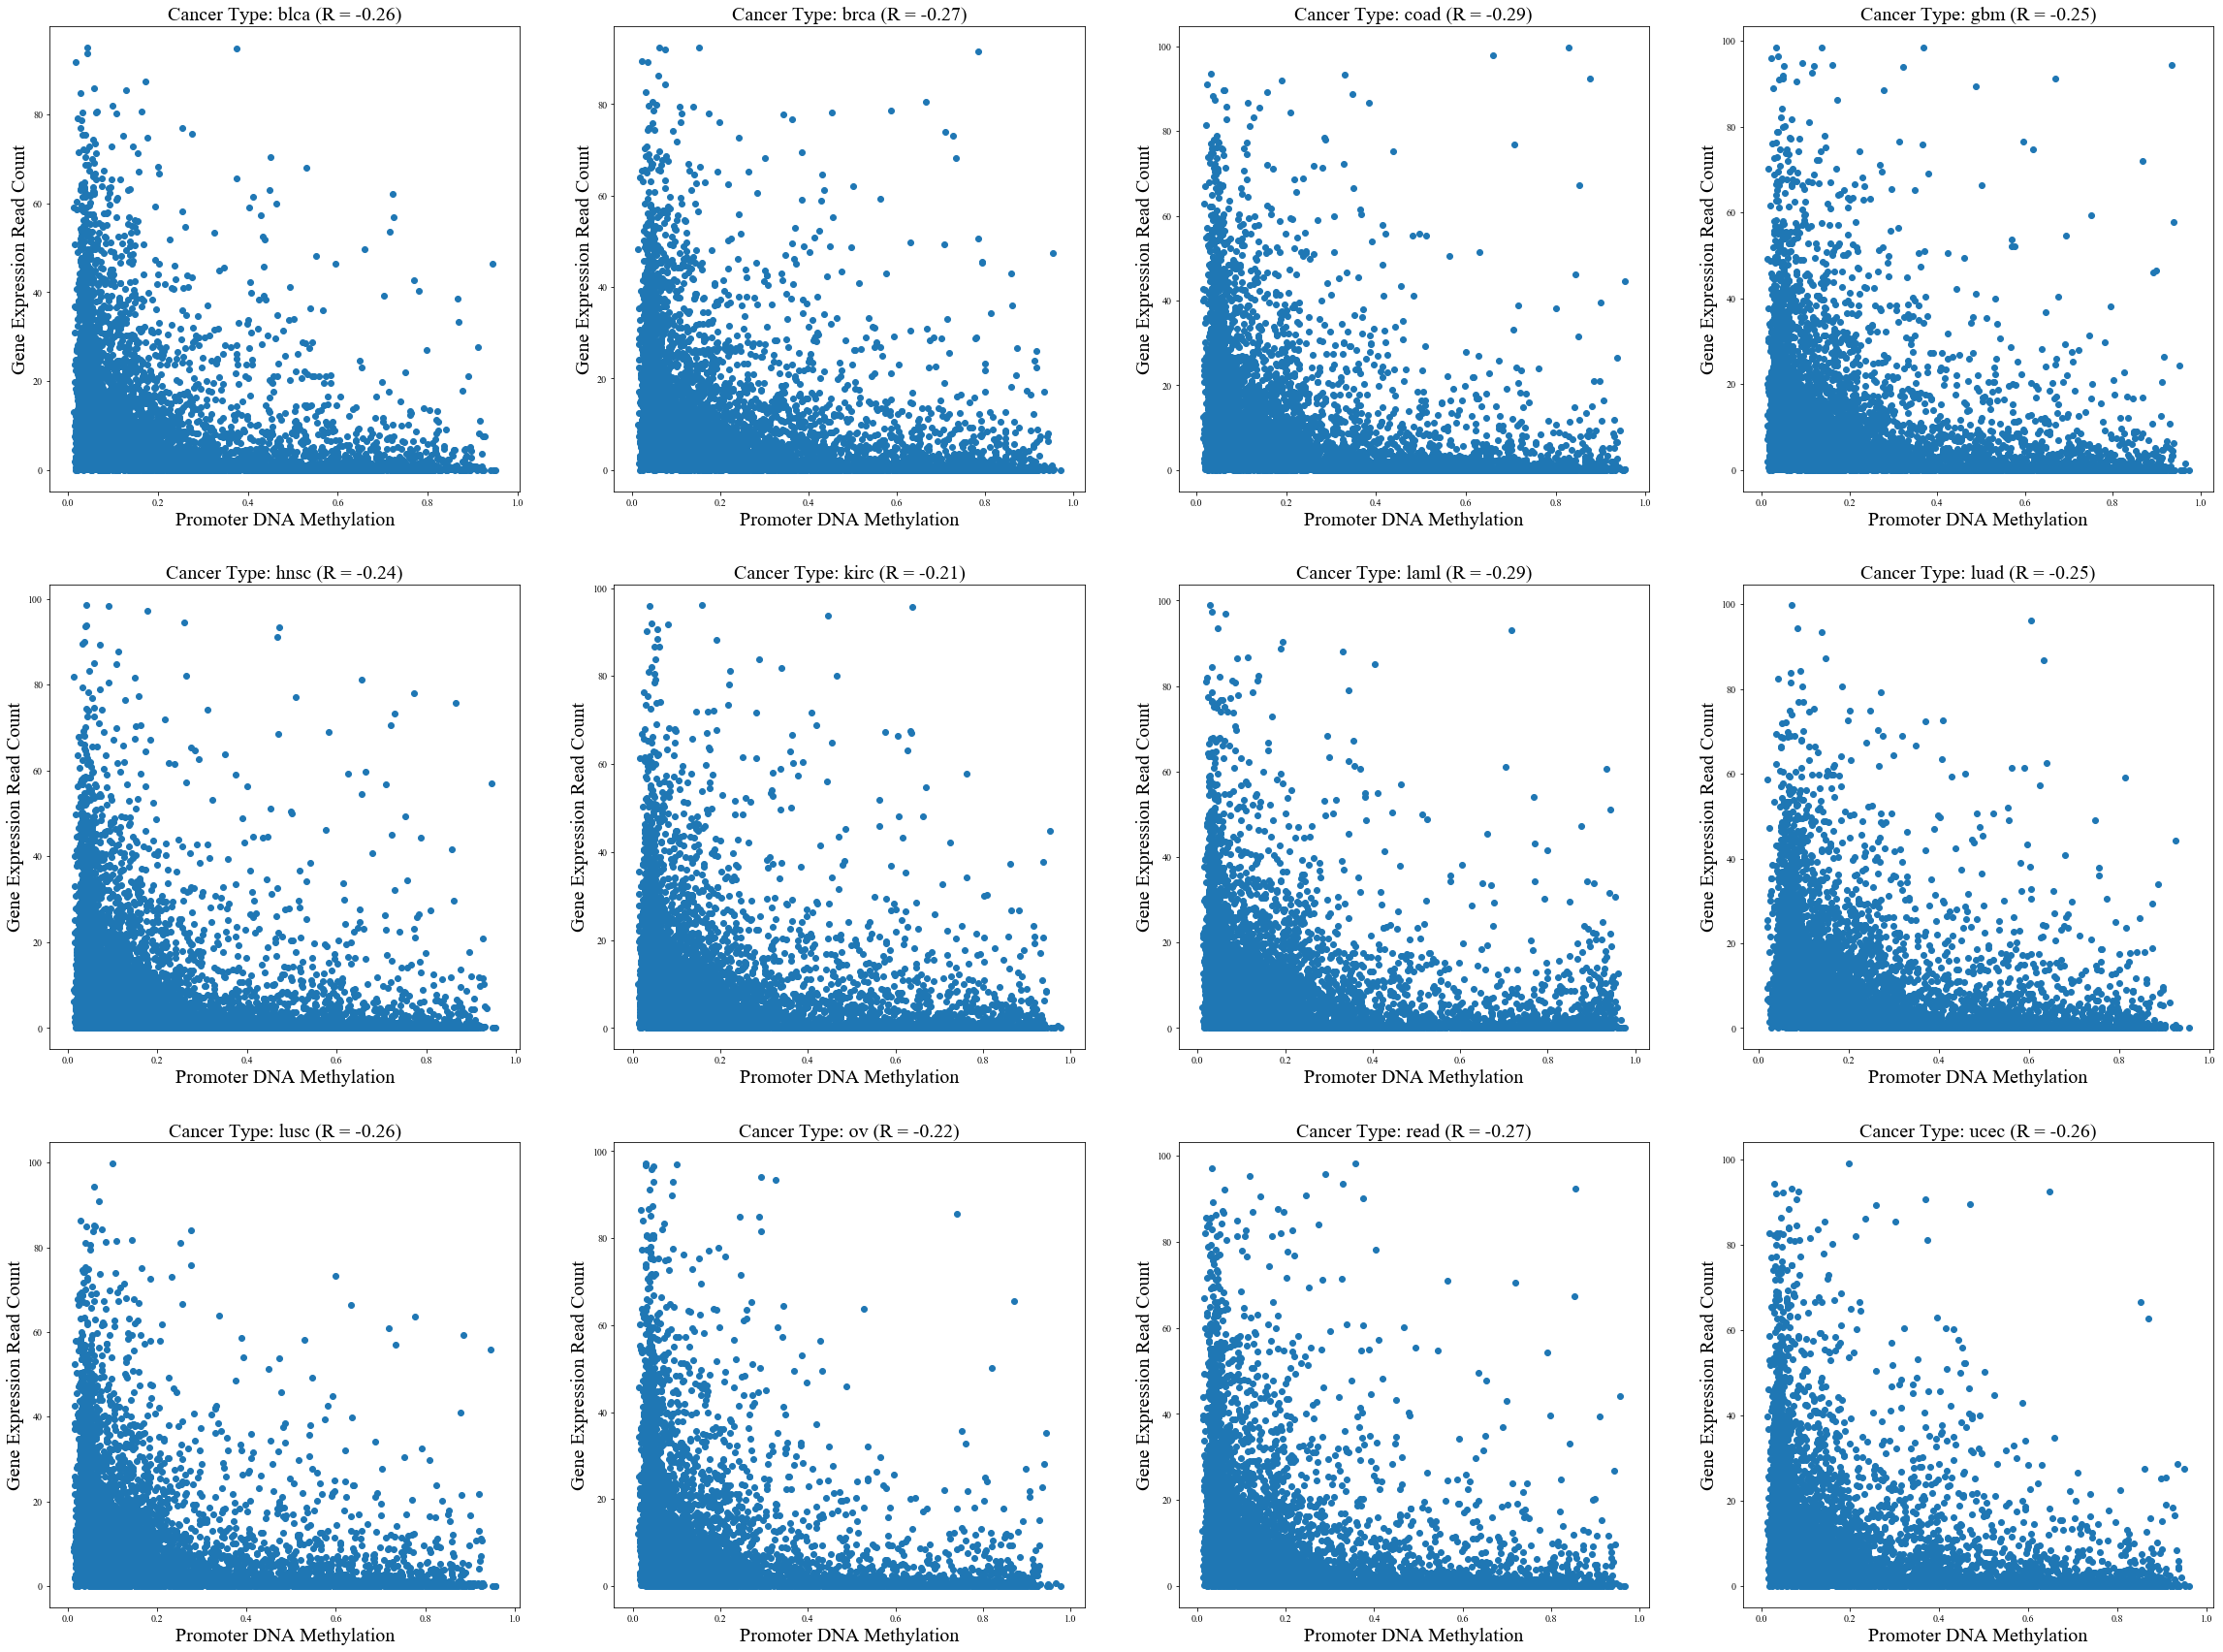

In [9]:
F_valid = F_df[(F_df_nomutfreq == 0).sum(axis=1) < 3]
fig = plt.figure(figsize=(40, 30))
c = 1
for i in ['blca','brca','coad','gbm','hnsc','kirc','laml','luad','lusc','ov', 'read', 'ucec']:
    plt.subplot(3, 4, c)
    plt.scatter(F_valid['meth_{}_prom'.format(i)], F_valid['ge_{}'.format(i)])
    corr_coef = F_valid['meth_{}_prom'.format(i)].corr(F_valid['ge_{}'.format(i)])
    plt.title('Cancer Type: {0:} (R = {1:.2f})'.format(i, corr_coef), fontsize=20)
    plt.xlabel('Promoter DNA Methylation', fontsize=20)
    plt.ylabel('Gene Expression Read Count', fontsize=20)
    c += 1
fig.savefig('../../data/pancancer/TCGA/methylation/correlation_ge_meth.png', dpi=300)

In [14]:
cols = [c for c in F_df.columns if not c.startswith('mutfreq')]
F_df[F_df.index.str.startswith('BRCA')][cols]

,meth_blca_prom,meth_brca_prom,meth_coad_prom,meth_gbm_prom,meth_hnsc_prom,meth_kirc_prom,meth_laml_prom,meth_luad_prom,meth_lusc_prom,meth_ov_prom,...,ge_coad,ge_gbm,ge_hnsc,ge_kirc,ge_laml,ge_luad,ge_lusc,ge_ov,ge_read,ge_ucec
BRCA1,0.050,0.060,0.048,0.055,0.051,0.047,0.049,0.073,0.051,0.046,...,3.587,2.199,2.980,0.875,8.779,2.127,3.123,1.209,3.290,2.087
BRCA2,0.026,0.029,0.030,0.028,0.028,0.026,0.021,0.051,0.026,0.025,...,1.704,0.504,1.090,0.440,5.065,0.843,1.053,0.680,1.430,0.845


In [23]:
cols = [c for c in F_df.columns if c.startswith('meth')]
F_df[cols].idxmax()

meth_blca_prom     SYCP3
meth_brca_prom     CRYAA
meth_coad_prom     MORN3
meth_gbm_prom      CRYAA
meth_hnsc_prom     RGPD4
meth_kirc_prom     CRYAA
meth_laml_prom     CRYAA
meth_luad_prom     CRYAA
meth_lusc_prom     RGPD4
meth_ov_prom       CRYAA
meth_read_prom    H2AFB1
meth_ucec_prom     CRYAA
dtype: object